Installing libraries

In [3]:
!pip install tensorflow tensorflow_hub tensorflow_text keras_nlp pandas scikit-learn matplotlib -q

Import

In [4]:
import tensorflow as tf
import keras_nlp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Optimize TensorFlow for performance


In [5]:
tf.config.optimizer.set_jit(True)  # Enable XLA JIT compilation
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Dataset


In [6]:
# Option 1: Using Keras datasets API with a SMALLER vocab size
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=5000)  # Reduced from 10000

# Convert word indices back to words for use with BERT
word_index = tf.keras.datasets.imdb.get_word_index()
# Shift indices by 3 because 0, 1, and 2 are reserved indices
word_index = {k: (v + 3) for k, v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
reverse_word_index = {value: key for key, value in word_index.items()}

# Function to convert the indices back to text
def convert_indices_to_text(indices):
    return ' '.join([reverse_word_index.get(i, '?') for i in indices])

train_sample_size = 5000
test_sample_size = 1000

# Sample the data
np.random.seed(42)
train_indices = np.random.choice(len(x_train), train_sample_size, replace=False)
test_indices = np.random.choice(len(x_test), test_sample_size, replace=False)

x_train_sampled = [x_train[i] for i in train_indices]
y_train_sampled = [y_train[i] for i in train_indices]
x_test_sampled = [x_test[i] for i in test_indices]
y_test_sampled = [y_test[i] for i in test_indices]

# Convert numerical sequences back to text
x_train_text = [convert_indices_to_text(x) for x in x_train_sampled]
x_test_text = [convert_indices_to_text(x) for x in x_test_sampled]
y_train = np.array(y_train_sampled)
y_test = np.array(y_test_sampled)

# Split the training data into training and validation sets
x_train_text, x_val_text, y_train, y_val = train_test_split(
    x_train_text, y_train, test_size=0.1, random_state=42
)

print(f"Training set size: {len(x_train_text)}")
print(f"Validation set size: {len(x_val_text)}")
print(f"Test set size: {len(x_test_text)}")

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set size: 4500
Validation set size: 500
Test set size: 1000


# BERT-based Classification Model

In [7]:
classifier = keras_nlp.models.BertClassifier.from_preset(
    "bert_tiny_en_uncased",  # Much smaller model than bert_base
    num_classes=1,  # Binary classification: 1 unit with sigmoid
    activation="sigmoid"
)

tf.keras.mixed_precision.set_global_policy('mixed_float16')

classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),  # Slightly higher learning rate
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print("BERT classifier created successfully!")

# Display model summary
print("\nModel Summary:")
classifier.summary(line_length=100)

100%|██████████| 507/507 [00:00<00:00, 593kB/s]


BERT classifier created successfully!

Model Summary:


Preprocessor: "bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                             ┃                                Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                           │                    Vocab size: 30,522 │
└──────────────────────────────────────────────────────────┴───────────────────────────────────────┘

Model: "bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)   │ (None, None)            │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ segment_ids (InputLayer)    │ (None, None)            │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ token_ids (InputLayer)      │ (None, None)            │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ bert_backbone               │ [(None, 128), (None,    │      4,385,920 │ padding_mask[0][0],     │
│ (BertBackbone)              │ None, 128)]             │                │ segment_ids[0][0],      │
│                             │                         │                │ token_ids[0][0]         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ classifier_dropout          │ (None, 128)             │              0 │ bert_backbone[0][0]     │
│ (Dropout)                   │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ logits (Dense)              │ (None, 1)               │            129 │ classifier_dropout[0][… │
└─────────────────────────────┴─────────────────────────┴────────────────┴─────────────────────────┘

 Total params: 4,386,049 (16.73 MB)

 Trainable params: 4,386,049 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

# BERT Fine-tuned for Sentiment Analysis

In [8]:
# Set up larger batch size for speedup
batch_size = 32  # Increased from 16

classifier.backbone.trainable = True

# Train for fewer epochs
history = classifier.fit(
    x_train_text,
    y_train,
    epochs=1,  # Reduced to just 1 epoch
    batch_size=batch_size,
    validation_data=(x_val_text, y_val),
    verbose=1
)

141/141 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - accuracy: 0.5510 - loss: 0.6837 - val_accuracy: 0.6760 - val_loss: 0.6202


# Evaluation

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.60      0.66       505
           1       0.65      0.76      0.70       495

    accuracy                           0.68      1000
   macro avg       0.68      0.68      0.68      1000
weighted avg       0.68      0.68      0.68      1000



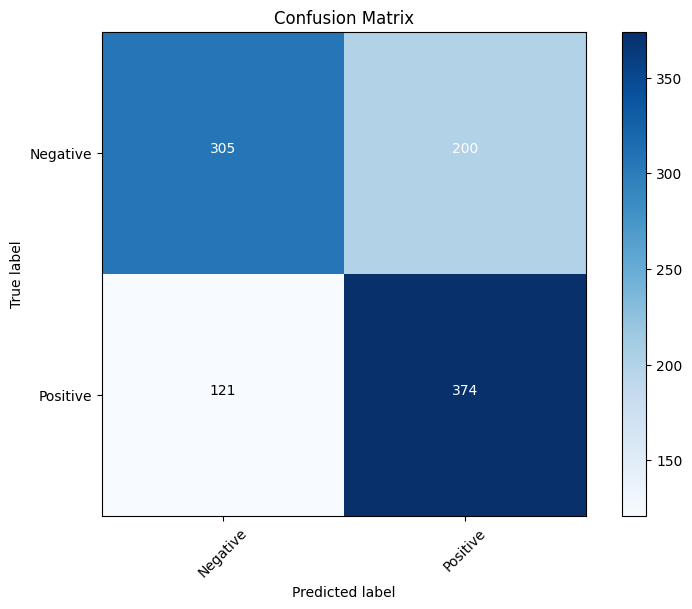

In [9]:
# 4.1 Make predictions on the test set (with larger batch size)
y_pred_proba = classifier.predict(x_test_text, batch_size=batch_size)
y_pred = (y_pred_proba > 0.5).astype(int)

# 4.2 Calculate and print metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 4.3 Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
plt.yticks(tick_marks, ['Negative', 'Positive'])

# Add text annotations to the confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png')
plt.show()

# Examples


In [10]:
# 5.1 Define new example reviews
new_reviews = [
    "This movie was excellent! The acting was incredible and the plot was engaging throughout.",
    "Terrible film. Bad acting, confusing plot, and the ending made no sense.",
    "The movie was okay. Some parts were good, but overall it was just average.",
    "I absolutely loved this film! It's definitely going on my list of favorites.",
    "Waste of time and money. Don't bother watching this disaster."
]

# 5.2 Make predictions on new examples (with larger batch size)
new_predictions = classifier.predict(new_reviews, batch_size=5)  # Batch all examples together

# 5.3 Display results
print("\nPredictions for new reviews:")
for i, review in enumerate(new_reviews):
    # Truncate long reviews for display
    display_review = review[:75] + '...' if len(review) > 75 else review
    sentiment = "Positive" if new_predictions[i][0] > 0.5 else "Negative"
    confidence = new_predictions[i][0] if sentiment == "Positive" else 1 - new_predictions[i][0]
    print(f"Review: {display_review}")
    print(f"Prediction: {sentiment} (Confidence: {confidence:.4f})")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

Predictions for new reviews:
Review: This movie was excellent! The acting was incredible and the plot was engagi...
Prediction: Positive (Confidence: 0.5318)
--------------------------------------------------
Review: Terrible film. Bad acting, confusing plot, and the ending made no sense.
Prediction: Negative (Confidence: 0.5612)
--------------------------------------------------
Review: The movie was okay. Some parts were good, but overall it was just average.
Prediction: Positive (Confidence: 0.5185)
--------------------------------------------------
Review: I absolutely loved this film! It's definitely going on my list of favorites...
Prediction: Positive (Confidence: 0.5396)
--------------------------------------------------
Review: Waste of time and money. Don't bother watching this disaster.
Prediction: Negative (Confidence: 0.5628)
--------------------------------------------------
